In [1]:
import numpy as np
import pandas as pd
import os
import json
from copy import deepcopy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
%matplotlib notebook

In [3]:
np.fmod(3.0, 2.5)

0.5

In [4]:
np.arccos(0)

1.5707963267948966

In [5]:
def fibonacci(n):
    if n == 0:
        return 8
    if n == 1:
        return 13
    return fibonacci(n-1) + fibonacci(n-2)

def zcw_from_cnst(m, c1, c2, c3):
    n_m = fibonacci(m+2)
    f_m = fibonacci(m)
    results = []
    for i in range(n_m):
        alpha = 2.0 * np.pi / c3 * np.fmod(i * f_m / n_m, 1.0)
        beta = np.arccos(c1 * (c2 * np.fmod(i/n_m, 1.0) - 1.0))
        results.append([alpha, beta, 0.0])
    return results

def zcw2(n, option):
    if option == 'full':
        return zcw_from_cnst(n, 1, 2, 1)
    elif option == 'hemi':
        return zcw_from_cnst(n, -1, 1, 1)
    elif option == 'octant':
        return zcw_from_cnst(n, -1, 1, 4)
    
def zcw3(n, option, gamma_cnt):
    eulers = zcw2(n, option)
    if gamma_cnt < 2:
        return eulers
    gamma_step = np.pi * 2 / gamma_cnt
    results = []
    for euler in eulers:
        for i in range(gamma_cnt):
            temp = euler[:]
            temp[2] = i * gamma_step
            results.append(temp)
    return results

In [6]:
def getXYZ(r, phi, theta):
    z = r * np.cos(theta)
    xy = r * np.sin(theta)
    x = xy * np.cos(phi)
    y = xy * np.sin(phi)
    return x, y, z

34 eulers generated...


<IPython.core.display.Javascript object>


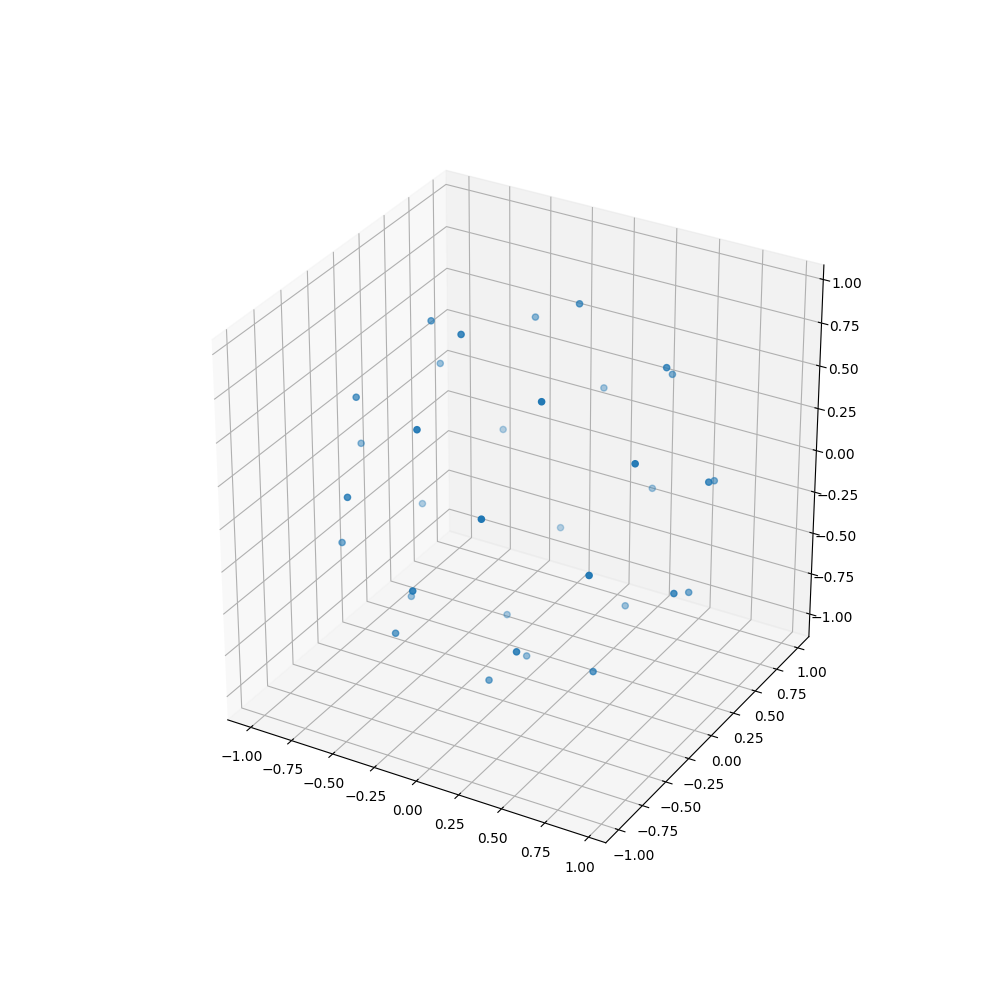

In [7]:
eulers = zcw2(1, 'full')
print(f'{len(eulers)} eulers generated...')
xs = []
ys = []
zs = []
for euler in eulers:
    x, y, z = getXYZ(1.0, euler[0], euler[1])
    xs.append(x)
    ys.append(y)
    zs.append(z)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs, ys, zs)
plt.show()

In [8]:
def fp_to_intensities(filename, destdir):
    categories = [
        'field range',
        'emr range'
    ]
    with open(filename) as f:
        data = json.load(f)
    
    if not os.path.exists(destdir):
        os.makedirs(destdir)
        print(f'destination: {destdir}')
        
    orig_task = data["settings"]["task"]
    print(f'break task [{orig_task}] into individual intensities...')
    new_task = "PowderIntensity"
    
    if "emr range" in data["settings"]:
        key_to_change = "em_frequency"
        beg = data["settings"]["emr range"]["begin"]
        end = data["settings"]["emr range"]["end"]
        step = data["settings"]["emr range"]["step"]
    else:
        key_to_change = "b0"
        beg = data["settings"]["field range"]["begin"]
        end = data["settings"]["field range"]["end"]
        step = data["settings"]["field range"]["step"]
    beg = float(beg)
    end = float(end)
    step = float(step)
    vals = []
    val = beg
    while val < end + 1e-7:
        vals.append(val)
        val += step
    
    new_name_prefix = os.path.basename(filename).split('.json')[0]
    for i, val in enumerate(vals):
        new_name = f'fp_{i}.json'
        new_path = os.path.join(destdir, new_name)
        temp = deepcopy(data)
        temp["settings"]["task"] = new_task
        temp["settings"]["ncores"] = 1
        if key_to_change == "em_frequency":
            temp["settings"]["Gyrotron"][key_to_change] = val
        else:
            temp["settings"]["Magnet"][key_to_change] = val
        with open(new_path, 'w') as js_file:
            json.dump(temp, js_file, indent=2)
            print('.', end='')
    print()

In [9]:
def fp_to_intensities_per_euler(filename, destdir, eulers):
    if not os.path.exists(destdir):
        os.makedirs(destdir)
        print(f'destination: {destdir}')
    euler_log_path = os.path.join(destdir, 'eulers.log')
    with open(euler_log_path, 'w+') as f:
        f.write('#index, alpha, beta, gamma\n')
        for i, euler in enumerate(eulers):
            a, b, g = euler
            line = f'{i}, {a}, {b}, {g}\n'
            f.write(line)
    print()
    for i, euler in enumerate(eulers):
        with open(filename, 'r', encoding='utf-8') as f:
            data = json.load(f)
            data['settings']['euler']['alpha'] = euler[0]
            data['settings']['euler']['beta'] = euler[1]
            data['settings']['euler']['gamma'] = euler[2]
            if 'euler_scheme' in data['settings']:
                data['settings'].pop('euler_scheme')
            data['settings']['eulers'] = []
            data['settings']['eulers'].append({
                'alpha': 0.0,
                'beta': np.pi/2.0,
                'gamma': 0.0
            })
            
        temp_filename = os.path.basename(filename)
        temp_path = os.path.join(destdir, temp_filename)
        
        with open(temp_path, 'w', encoding='utf-8') as f:
            json.dump(data, f, indent=2)
        subname = f'euler_{i}'
        subdir = os.path.join(destdir, subname)
        fp_to_intensities(temp_path, subdir)
        print('.', end='')
    print()

In [11]:
os.getcwd()

'/home/chen/coding/projects/dnpsoup/dnpsoup_analytics/eofe_inputs'

In [12]:
def getXYZ(r, phi, theta):
    z = r * np.cos(theta/180. * np.pi)
    xy = r * np.sin(theta/180. * np.pi)
    x = xy * np.cos(phi/180. * np.pi)
    y = xy * np.sin(phi/180. * np.pi)
    return x, y, z

In [13]:
getXYZ(2.36, 0, 100)

(2.3241462971088107, 0.0, -0.4098096992939555)

In [14]:
getXYZ(2.36, 5, -100)

(-2.31530221876936, -0.2025626967787378, -0.4098096992939555)

In [15]:
10, -90
10, -110
-10, -100
-10, -90
-10, -110

(-10, -110)

In [16]:
getXYZ(2.36, -10, -140)

(-1.4939324428803942, 0.26342059703552123, -1.8078648857607877)

### Generate Slurm Inputs per Field Point

In [222]:
orig_dir = '../inputs/CE/TEKPol/ZCW_3angles/eulers/'
spin_str = 'eeH'
euler_str = 'an10bn140g0'
t_str = 't1e0p6ms_t2e3us_t1n2s_t2n1ms'
zcw_str = 'ZCW34_g12'
emr = '0p4MHz'

filename = f'TEKPol_{spin_str}_{euler_str}_{t_str}_{emr}_3s_inc40ns_{zcw_str}_fp51.json'
dest_parent = 'CE/TEKPol_fp'
dest_dirname = f'{spin_str}_{euler_str}_{t_str}_{zcw_str}_{emr}'
# =====================================

dest_root = os.path.join(dest_parent, dest_dirname)
if not os.path.exists(dest_root):
    os.makedirs(dest_root)
orig_path = os.path.join(orig_dir, filename)
dest_path = os.path.join(dest_root, dest_dirname)
fp_to_intensities(orig_path, dest_path)

# ===================================
print('config files')
config_name = f'{dest_dirname}.config'
n_tasks = len(list(os.listdir(dest_path)))
dest_config_path = os.path.join(dest_root, config_name)
with open(dest_config_path, 'w+') as f:
    for i in range(n_tasks):
        exe_str = '/home/cyang019/coding/projects/dnpsoup/build/dnpsoup_cli/dnpsoup_exec'
        common_str = f'/home/cyang019/workspace/CE/tasks/{dest_dirname}'
        file_part = f'{common_str}/{dest_dirname}/fp_{i}.json'
        output_part = f'{common_str}/{dest_dirname}_results/fp_{i}.result'
        line = f'{i} {exe_str} {file_part} {output_part}\n'
        f.write(line)
print('finished.')

# ================================
print('sbatch file')
sbatch_name = f'CE_fp.sh'
dest_sbatch_path = os.path.join(dest_root, sbatch_name)
with open(dest_sbatch_path, 'w+') as f:
    f.write('#!/bin/bash\n')
    f.write('#SBATCH -p sched_mit_psfc\n')
    f.write(f'#SBATCH --ntasks={n_tasks}\n')
    f.write('#SBATCH --cpus-per-task=1\n')
    f.write('#SBATCH -J CE\n')
    f.write('#SBATCH --export=OMP_NUM_THREADS,ALL\n')
    f.write('module rm gcc/4.8.4\n')
    f.write('module add gcc/8.3.0\n')
    f.write('module load gcc/8.3.0\n')
    f.write('\n# launch the code\n')
    f.write('export OMP_NUM_THREAD=1\n')
    f.write(f'srun --multi-prog {config_name}\n')

# =================================
print('reference jobs...')
common_name = filename.split('.')[0]
filename2 = f'{common_name}_ref.json'
dest_dirname2 = f'{dest_dirname}_ref'

with open(orig_path, 'r', encoding='utf-8') as f:
    temp = json.load(f)
temp['pulseseq']['components']['emr1']['e']['frequency'] = 0
orig_path = os.path.join(orig_dir, filename2)
dest_path = os.path.join(dest_root, dest_dirname2)
with open(orig_path, 'w', encoding='utf-8') as f:
    json.dump(temp, f, indent=2)
fp_to_intensities(orig_path, dest_path)

# ===================================
print('config files')
config_name = f'{dest_dirname2}.config'
n_tasks = len(list(os.listdir(dest_path)))
dest_config_path = os.path.join(dest_root, config_name)
with open(dest_config_path, 'w+') as f:
    for i in range(n_tasks):
        exe_str = '/home/cyang019/coding/projects/dnpsoup/build/dnpsoup_cli/dnpsoup_exec'
        common_str = f'/home/cyang019/workspace/CE/tasks/{dest_dirname}'
        file_part = f'{common_str}/{dest_dirname2}/fp_{i}.json'
        output_part = f'{common_str}/{dest_dirname2}_results/fp_{i}.result'
        line = f'{i} {exe_str} {file_part} {output_part}\n'
        f.write(line)
        
# ================================
print('sbatch file')
sbatch_name = f'CE_fp_ref.sh'
dest_sbatch_path = os.path.join(dest_root, sbatch_name)
with open(dest_sbatch_path, 'w+') as f:
    f.write('#!/bin/bash\n')
    f.write('#SBATCH -p sched_mit_psfc\n')
    f.write(f'#SBATCH --ntasks={n_tasks}\n')
    f.write('#SBATCH --cpus-per-task=1\n')
    f.write('#SBATCH -J CE\n')
    f.write('#SBATCH --export=OMP_NUM_THREADS,ALL\n')
    f.write('module rm gcc/4.8.4\n')
    f.write('module add gcc/8.3.0\n')
    f.write('module load gcc/8.3.0\n')
    f.write('\n# launch the code\n')
    f.write('export OMP_NUM_THREAD=1\n')
    f.write(f'srun --multi-prog {config_name}\n')
print('finished.')

destination: CE/TEKPol_fp/eeH_an10bn140g0_t1e0p6ms_t2e3us_t1n2s_t2n1ms_ZCW34_g12_0p4MHz/eeH_an10bn140g0_t1e0p6ms_t2e3us_t1n2s_t2n1ms_ZCW34_g12_0p4MHz
break task [FieldProfile] into individual intensities...
....................................................
config files
finished.
sbatch file
reference jobs...
destination: CE/TEKPol_fp/eeH_an10bn140g0_t1e0p6ms_t2e3us_t1n2s_t2n1ms_ZCW34_g12_0p4MHz/eeH_an10bn140g0_t1e0p6ms_t2e3us_t1n2s_t2n1ms_ZCW34_g12_0p4MHz_ref
break task [FieldProfile] into individual intensities...
....................................................
config files
sbatch file
finished.


### Generate Slurm Inputs per Field Point **per Euler**

In [134]:
orig_dir = '../inputs/CE/TEKPol/eeHN/'
spin_str = 'eeHN'
euler_str = 'a0b105g0'
t_str = 't1e0p6ms_t2e3us_t1n2s_t2n1ms'
zcw_str = 'xtal'

eulers = zcw3(1, 'full', 6)
print(f'{len(eulers)} euler angles generated...')
_an20bn130g
filename = f'TEKPol_{spin_str}_{euler_str}_{t_str}_0p35MHz_3s_inc40ns_{zcw_str}_fp.json'
dest_parent = 'CE/TEKPol_fp'
dest_dirname = f'{spin_str}_{euler_str}_{t_str}_euler{len(eulers)}'
# =====================================

dest_root = os.path.join(dest_parent, dest_dirname)
if not os.path.exists(dest_root):
    os.makedirs(dest_root)
orig_path = os.path.join(orig_dir, filename)
dest_path = os.path.join(dest_root, dest_dirname)
fp_to_intensities_per_euler(orig_path, dest_path, eulers)

# ===================================
print('config files')
for sub_name in os.listdir(dest_path):
    sub_path = os.path.join(dest_path, sub_name)
    if os.path.isdir(sub_path):
        config_name = f'{dest_dirname}_{sub_name}.config'
        n_tasks = len(list(os.listdir(sub_path)))
        dest_config_path = os.path.join(dest_path, config_name)
        with open(dest_config_path, 'w+') as f:
            for i in range(n_tasks):
                exe_str = '/home/cyang019/coding/projects/dnpsoup/build/dnpsoup_cli/dnpsoup_exec'
                common_str = f'/home/cyang019/workspace/CE/tasks/{dest_dirname}'
                file_part = f'{common_str}/{dest_dirname}/{sub_name}/fp_{i}.json'
                output_part = f'{common_str}/{dest_dirname}/{sub_name}_results/fp_{i}.result'
                line = f'{i} {exe_str} {file_part} {output_part}\n'
                f.write(line)

        # ================================
        sbatch_name = f'{sub_name}_fp.sh'
        dest_sbatch_path = os.path.join(dest_path, sbatch_name)
        with open(dest_sbatch_path, 'w+') as f:
            f.write('#!/bin/bash\n')
            f.write('#SBATCH -p sched_mit_psfc\n')
            f.write(f'#SBATCH --ntasks={n_tasks}\n')
            f.write('#SBATCH --cpus-per-task=1\n')
            f.write('#SBATCH -J CE\n')
            f.write('#SBATCH --export=OMP_NUM_THREADS,ALL\n')
            f.write('module rm gcc/4.8.4\n')
            f.write('module add gcc/8.3.0\n')
            f.write('module load gcc/8.3.0\n')
            f.write('\n# launch the code\n')
            f.write('export OMP_NUM_THREAD=1\n')
            f.write(f'srun --multi-prog {config_name}\n')
    print('.', end='')
print()
print('finished.')


# =================================
print('reference jobs...')
common_name = filename.split('.')[0]
filename2 = f'{common_name}_ref.json'
dest_dirname2 = f'{dest_dirname}_ref'
orig_path = os.path.join(orig_dir, filename2)
dest_path = os.path.join(dest_root, dest_dirname2)
fp_to_intensities_per_euler(orig_path, dest_path, eulers)

# ===================================
print('config files')
for sub_name in os.listdir(dest_path):
    sub_path = os.path.join(dest_path, sub_name)
    if os.path.isdir(sub_path):
        config_name = f'{dest_dirname2}_{sub_name}.config'
        n_tasks = len(list(os.listdir(sub_path)))
        dest_config_path = os.path.join(dest_path, config_name)
        with open(dest_config_path, 'w+') as f:
            for i in range(n_tasks):
                exe_str = '/home/cyang019/coding/projects/dnpsoup/build/dnpsoup_cli/dnpsoup_exec'
                common_str = f'/home/cyang019/workspace/CE/tasks/{dest_dirname}'
                file_part = f'{common_str}/{dest_dirname2}/{sub_name}/fp_{i}.json'
                output_part = f'{common_str}/{dest_dirname2}/{sub_name}_results/fp_{i}.result'
                line = f'{i} {exe_str} {file_part} {output_part}\n'
                f.write(line)

        # ================================
        print('sbatch file')
        sbatch_name = f'{sub_name}_fp_ref.sh'
        dest_sbatch_path = os.path.join(dest_path, sbatch_name)
        with open(dest_sbatch_path, 'w+') as f:
            f.write('#!/bin/bash\n')
            f.write('#SBATCH -p sched_mit_psfc\n')
            f.write(f'#SBATCH --ntasks={n_tasks}\n')
            f.write('#SBATCH --cpus-per-task=1\n')
            f.write('#SBATCH -J CE\n')
            f.write('#SBATCH --export=OMP_NUM_THREADS,ALL\n')
            f.write('module rm gcc/4.8.4\n')
            f.write('module add gcc/8.3.0\n')
            f.write('module load gcc/8.3.0\n')
            f.write('\n# launch the code\n')
            f.write('export OMP_NUM_THREAD=1\n')
            f.write(f'srun --multi-prog {config_name}\n')
    print('.', end='')
print()
print('finished.')

204 euler angles generated...

destination: CE/TEKPol_fp/eeHN_a0b105g0_t1e0p6ms_t2e3us_t1n2s_t2n1ms_euler204/eeHN_a0b105g0_t1e0p6ms_t2e3us_t1n2s_t2n1ms_euler204/euler_0
break task [FieldProfile] into individual intensities...
....................................................
.destination: CE/TEKPol_fp/eeHN_a0b105g0_t1e0p6ms_t2e3us_t1n2s_t2n1ms_euler204/eeHN_a0b105g0_t1e0p6ms_t2e3us_t1n2s_t2n1ms_euler204/euler_1
break task [FieldProfile] into individual intensities...
....................................................
.destination: CE/TEKPol_fp/eeHN_a0b105g0_t1e0p6ms_t2e3us_t1n2s_t2n1ms_euler204/eeHN_a0b105g0_t1e0p6ms_t2e3us_t1n2s_t2n1ms_euler204/euler_2
break task [FieldProfile] into individual intensities...
....................................................
.destination: CE/TEKPol_fp/eeHN_a0b105g0_t1e0p6ms_t2e3us_t1n2s_t2n1ms_euler204/eeHN_a0b105g0_t1e0p6ms_t2e3us_t1n2s_t2n1ms_euler204/euler_3
break task [FieldProfile] into individual intensities...
...........................

....................................................
.destination: CE/TEKPol_fp/eeHN_a0b105g0_t1e0p6ms_t2e3us_t1n2s_t2n1ms_euler204/eeHN_a0b105g0_t1e0p6ms_t2e3us_t1n2s_t2n1ms_euler204/euler_34
break task [FieldProfile] into individual intensities...
....................................................
.destination: CE/TEKPol_fp/eeHN_a0b105g0_t1e0p6ms_t2e3us_t1n2s_t2n1ms_euler204/eeHN_a0b105g0_t1e0p6ms_t2e3us_t1n2s_t2n1ms_euler204/euler_35
break task [FieldProfile] into individual intensities...
....................................................
.destination: CE/TEKPol_fp/eeHN_a0b105g0_t1e0p6ms_t2e3us_t1n2s_t2n1ms_euler204/eeHN_a0b105g0_t1e0p6ms_t2e3us_t1n2s_t2n1ms_euler204/euler_36
break task [FieldProfile] into individual intensities...
....................................................
.destination: CE/TEKPol_fp/eeHN_a0b105g0_t1e0p6ms_t2e3us_t1n2s_t2n1ms_euler204/eeHN_a0b105g0_t1e0p6ms_t2e3us_t1n2s_t2n1ms_euler204/euler_37
break task [FieldProfile] into individual intensities...


....................................................
.destination: CE/TEKPol_fp/eeHN_a0b105g0_t1e0p6ms_t2e3us_t1n2s_t2n1ms_euler204/eeHN_a0b105g0_t1e0p6ms_t2e3us_t1n2s_t2n1ms_euler204/euler_69
break task [FieldProfile] into individual intensities...
....................................................
.destination: CE/TEKPol_fp/eeHN_a0b105g0_t1e0p6ms_t2e3us_t1n2s_t2n1ms_euler204/eeHN_a0b105g0_t1e0p6ms_t2e3us_t1n2s_t2n1ms_euler204/euler_70
break task [FieldProfile] into individual intensities...
....................................................
.destination: CE/TEKPol_fp/eeHN_a0b105g0_t1e0p6ms_t2e3us_t1n2s_t2n1ms_euler204/eeHN_a0b105g0_t1e0p6ms_t2e3us_t1n2s_t2n1ms_euler204/euler_71
break task [FieldProfile] into individual intensities...
....................................................
.destination: CE/TEKPol_fp/eeHN_a0b105g0_t1e0p6ms_t2e3us_t1n2s_t2n1ms_euler204/eeHN_a0b105g0_t1e0p6ms_t2e3us_t1n2s_t2n1ms_euler204/euler_72
break task [FieldProfile] into individual intensities...


....................................................
.destination: CE/TEKPol_fp/eeHN_a0b105g0_t1e0p6ms_t2e3us_t1n2s_t2n1ms_euler204/eeHN_a0b105g0_t1e0p6ms_t2e3us_t1n2s_t2n1ms_euler204/euler_102
break task [FieldProfile] into individual intensities...
....................................................
.destination: CE/TEKPol_fp/eeHN_a0b105g0_t1e0p6ms_t2e3us_t1n2s_t2n1ms_euler204/eeHN_a0b105g0_t1e0p6ms_t2e3us_t1n2s_t2n1ms_euler204/euler_103
break task [FieldProfile] into individual intensities...
....................................................
.destination: CE/TEKPol_fp/eeHN_a0b105g0_t1e0p6ms_t2e3us_t1n2s_t2n1ms_euler204/eeHN_a0b105g0_t1e0p6ms_t2e3us_t1n2s_t2n1ms_euler204/euler_104
break task [FieldProfile] into individual intensities...
....................................................
.destination: CE/TEKPol_fp/eeHN_a0b105g0_t1e0p6ms_t2e3us_t1n2s_t2n1ms_euler204/eeHN_a0b105g0_t1e0p6ms_t2e3us_t1n2s_t2n1ms_euler204/euler_105
break task [FieldProfile] into individual intensities

....................................................
.destination: CE/TEKPol_fp/eeHN_a0b105g0_t1e0p6ms_t2e3us_t1n2s_t2n1ms_euler204/eeHN_a0b105g0_t1e0p6ms_t2e3us_t1n2s_t2n1ms_euler204/euler_136
break task [FieldProfile] into individual intensities...
....................................................
.destination: CE/TEKPol_fp/eeHN_a0b105g0_t1e0p6ms_t2e3us_t1n2s_t2n1ms_euler204/eeHN_a0b105g0_t1e0p6ms_t2e3us_t1n2s_t2n1ms_euler204/euler_137
break task [FieldProfile] into individual intensities...
....................................................
.destination: CE/TEKPol_fp/eeHN_a0b105g0_t1e0p6ms_t2e3us_t1n2s_t2n1ms_euler204/eeHN_a0b105g0_t1e0p6ms_t2e3us_t1n2s_t2n1ms_euler204/euler_138
break task [FieldProfile] into individual intensities...
....................................................
.destination: CE/TEKPol_fp/eeHN_a0b105g0_t1e0p6ms_t2e3us_t1n2s_t2n1ms_euler204/eeHN_a0b105g0_t1e0p6ms_t2e3us_t1n2s_t2n1ms_euler204/euler_139
break task [FieldProfile] into individual intensities

....................................................
.destination: CE/TEKPol_fp/eeHN_a0b105g0_t1e0p6ms_t2e3us_t1n2s_t2n1ms_euler204/eeHN_a0b105g0_t1e0p6ms_t2e3us_t1n2s_t2n1ms_euler204/euler_170
break task [FieldProfile] into individual intensities...
....................................................
.destination: CE/TEKPol_fp/eeHN_a0b105g0_t1e0p6ms_t2e3us_t1n2s_t2n1ms_euler204/eeHN_a0b105g0_t1e0p6ms_t2e3us_t1n2s_t2n1ms_euler204/euler_171
break task [FieldProfile] into individual intensities...
....................................................
.destination: CE/TEKPol_fp/eeHN_a0b105g0_t1e0p6ms_t2e3us_t1n2s_t2n1ms_euler204/eeHN_a0b105g0_t1e0p6ms_t2e3us_t1n2s_t2n1ms_euler204/euler_172
break task [FieldProfile] into individual intensities...
....................................................
.destination: CE/TEKPol_fp/eeHN_a0b105g0_t1e0p6ms_t2e3us_t1n2s_t2n1ms_euler204/eeHN_a0b105g0_t1e0p6ms_t2e3us_t1n2s_t2n1ms_euler204/euler_173
break task [FieldProfile] into individual intensities

..............................................................................................................................................................................................................
finished.
reference jobs...
destination: CE/TEKPol_fp/eeHN_a0b105g0_t1e0p6ms_t2e3us_t1n2s_t2n1ms_euler204/eeHN_a0b105g0_t1e0p6ms_t2e3us_t1n2s_t2n1ms_euler204_ref

destination: CE/TEKPol_fp/eeHN_a0b105g0_t1e0p6ms_t2e3us_t1n2s_t2n1ms_euler204/eeHN_a0b105g0_t1e0p6ms_t2e3us_t1n2s_t2n1ms_euler204_ref/euler_0
break task [FieldProfile] into individual intensities...
....................................................
.destination: CE/TEKPol_fp/eeHN_a0b105g0_t1e0p6ms_t2e3us_t1n2s_t2n1ms_euler204/eeHN_a0b105g0_t1e0p6ms_t2e3us_t1n2s_t2n1ms_euler204_ref/euler_1
break task [FieldProfile] into individual intensities...
....................................................
.destination: CE/TEKPol_fp/eeHN_a0b105g0_t1e0p6ms_t2e3us_t1n2s_t2n1ms_euler204/eeHN_a0b105g0_t1e0p6ms_t2e3us_t1n2s_t2n1ms_eul

....................................................
.destination: CE/TEKPol_fp/eeHN_a0b105g0_t1e0p6ms_t2e3us_t1n2s_t2n1ms_euler204/eeHN_a0b105g0_t1e0p6ms_t2e3us_t1n2s_t2n1ms_euler204_ref/euler_32
break task [FieldProfile] into individual intensities...
....................................................
.destination: CE/TEKPol_fp/eeHN_a0b105g0_t1e0p6ms_t2e3us_t1n2s_t2n1ms_euler204/eeHN_a0b105g0_t1e0p6ms_t2e3us_t1n2s_t2n1ms_euler204_ref/euler_33
break task [FieldProfile] into individual intensities...
....................................................
.destination: CE/TEKPol_fp/eeHN_a0b105g0_t1e0p6ms_t2e3us_t1n2s_t2n1ms_euler204/eeHN_a0b105g0_t1e0p6ms_t2e3us_t1n2s_t2n1ms_euler204_ref/euler_34
break task [FieldProfile] into individual intensities...
....................................................
.destination: CE/TEKPol_fp/eeHN_a0b105g0_t1e0p6ms_t2e3us_t1n2s_t2n1ms_euler204/eeHN_a0b105g0_t1e0p6ms_t2e3us_t1n2s_t2n1ms_euler204_ref/euler_35
break task [FieldProfile] into individual

....................................................
.destination: CE/TEKPol_fp/eeHN_a0b105g0_t1e0p6ms_t2e3us_t1n2s_t2n1ms_euler204/eeHN_a0b105g0_t1e0p6ms_t2e3us_t1n2s_t2n1ms_euler204_ref/euler_66
break task [FieldProfile] into individual intensities...
....................................................
.destination: CE/TEKPol_fp/eeHN_a0b105g0_t1e0p6ms_t2e3us_t1n2s_t2n1ms_euler204/eeHN_a0b105g0_t1e0p6ms_t2e3us_t1n2s_t2n1ms_euler204_ref/euler_67
break task [FieldProfile] into individual intensities...
....................................................
.destination: CE/TEKPol_fp/eeHN_a0b105g0_t1e0p6ms_t2e3us_t1n2s_t2n1ms_euler204/eeHN_a0b105g0_t1e0p6ms_t2e3us_t1n2s_t2n1ms_euler204_ref/euler_68
break task [FieldProfile] into individual intensities...
....................................................
.destination: CE/TEKPol_fp/eeHN_a0b105g0_t1e0p6ms_t2e3us_t1n2s_t2n1ms_euler204/eeHN_a0b105g0_t1e0p6ms_t2e3us_t1n2s_t2n1ms_euler204_ref/euler_69
break task [FieldProfile] into individual

....................................................
.destination: CE/TEKPol_fp/eeHN_a0b105g0_t1e0p6ms_t2e3us_t1n2s_t2n1ms_euler204/eeHN_a0b105g0_t1e0p6ms_t2e3us_t1n2s_t2n1ms_euler204_ref/euler_100
break task [FieldProfile] into individual intensities...
....................................................
.destination: CE/TEKPol_fp/eeHN_a0b105g0_t1e0p6ms_t2e3us_t1n2s_t2n1ms_euler204/eeHN_a0b105g0_t1e0p6ms_t2e3us_t1n2s_t2n1ms_euler204_ref/euler_101
break task [FieldProfile] into individual intensities...
....................................................
.destination: CE/TEKPol_fp/eeHN_a0b105g0_t1e0p6ms_t2e3us_t1n2s_t2n1ms_euler204/eeHN_a0b105g0_t1e0p6ms_t2e3us_t1n2s_t2n1ms_euler204_ref/euler_102
break task [FieldProfile] into individual intensities...
....................................................
.destination: CE/TEKPol_fp/eeHN_a0b105g0_t1e0p6ms_t2e3us_t1n2s_t2n1ms_euler204/eeHN_a0b105g0_t1e0p6ms_t2e3us_t1n2s_t2n1ms_euler204_ref/euler_103
break task [FieldProfile] into indivi

....................................................
.destination: CE/TEKPol_fp/eeHN_a0b105g0_t1e0p6ms_t2e3us_t1n2s_t2n1ms_euler204/eeHN_a0b105g0_t1e0p6ms_t2e3us_t1n2s_t2n1ms_euler204_ref/euler_134
break task [FieldProfile] into individual intensities...
....................................................
.destination: CE/TEKPol_fp/eeHN_a0b105g0_t1e0p6ms_t2e3us_t1n2s_t2n1ms_euler204/eeHN_a0b105g0_t1e0p6ms_t2e3us_t1n2s_t2n1ms_euler204_ref/euler_135
break task [FieldProfile] into individual intensities...
....................................................
.destination: CE/TEKPol_fp/eeHN_a0b105g0_t1e0p6ms_t2e3us_t1n2s_t2n1ms_euler204/eeHN_a0b105g0_t1e0p6ms_t2e3us_t1n2s_t2n1ms_euler204_ref/euler_136
break task [FieldProfile] into individual intensities...
....................................................
.destination: CE/TEKPol_fp/eeHN_a0b105g0_t1e0p6ms_t2e3us_t1n2s_t2n1ms_euler204/eeHN_a0b105g0_t1e0p6ms_t2e3us_t1n2s_t2n1ms_euler204_ref/euler_137
break task [FieldProfile] into indivi

....................................................
.destination: CE/TEKPol_fp/eeHN_a0b105g0_t1e0p6ms_t2e3us_t1n2s_t2n1ms_euler204/eeHN_a0b105g0_t1e0p6ms_t2e3us_t1n2s_t2n1ms_euler204_ref/euler_168
break task [FieldProfile] into individual intensities...
....................................................
.destination: CE/TEKPol_fp/eeHN_a0b105g0_t1e0p6ms_t2e3us_t1n2s_t2n1ms_euler204/eeHN_a0b105g0_t1e0p6ms_t2e3us_t1n2s_t2n1ms_euler204_ref/euler_169
break task [FieldProfile] into individual intensities...
....................................................
.destination: CE/TEKPol_fp/eeHN_a0b105g0_t1e0p6ms_t2e3us_t1n2s_t2n1ms_euler204/eeHN_a0b105g0_t1e0p6ms_t2e3us_t1n2s_t2n1ms_euler204_ref/euler_170
break task [FieldProfile] into individual intensities...
....................................................
.destination: CE/TEKPol_fp/eeHN_a0b105g0_t1e0p6ms_t2e3us_t1n2s_t2n1ms_euler204/eeHN_a0b105g0_t1e0p6ms_t2e3us_t1n2s_t2n1ms_euler204_ref/euler_171
break task [FieldProfile] into indivi

....................................................
.destination: CE/TEKPol_fp/eeHN_a0b105g0_t1e0p6ms_t2e3us_t1n2s_t2n1ms_euler204/eeHN_a0b105g0_t1e0p6ms_t2e3us_t1n2s_t2n1ms_euler204_ref/euler_202
break task [FieldProfile] into individual intensities...
....................................................
.destination: CE/TEKPol_fp/eeHN_a0b105g0_t1e0p6ms_t2e3us_t1n2s_t2n1ms_euler204/eeHN_a0b105g0_t1e0p6ms_t2e3us_t1n2s_t2n1ms_euler204_ref/euler_203
break task [FieldProfile] into individual intensities...
....................................................
.
config files
sbatch file
.sbatch file
.sbatch file
.sbatch file
.sbatch file
.sbatch file
.sbatch file
.sbatch file
.sbatch file
.sbatch file
.sbatch file
.sbatch file
.sbatch file
.sbatch file
.sbatch file
.sbatch file
.sbatch file
.sbatch file
.sbatch file
.sbatch file
.sbatch file
.sbatch file
.sbatch file
.sbatch file
.sbatch file
.sbatch file
.sbatch file
.sbatch file
.sbatch file
.sbatch file
.sbatch file
.sbatch file
.sbatch

In [79]:
os.getcwd()

'/home/chen/coding/projects/dnpsoup/dnpsoup_analytics/eofe_inputs'

## Scan through Eulers with other settings fixed

In [59]:
center_euler = (0, -105, 0)
step_a, step_b = 5, 5
a_range = 30
b_range = 30
desired_eulers = []
for a in range(-a_range, a_range + step_a, step_a):
    for b in range(-b_range, b_range + step_b, step_b):
        euler = (a + center_euler[0], b + center_euler[1], 0)
        desired_eulers.append(euler)
print(f'Eulers to simulate: {len(desired_eulers)}')

Eulers to simulate: 169


In [60]:
desired_eulers

[(-30, -135, 0),
 (-30, -130, 0),
 (-30, -125, 0),
 (-30, -120, 0),
 (-30, -115, 0),
 (-30, -110, 0),
 (-30, -105, 0),
 (-30, -100, 0),
 (-30, -95, 0),
 (-30, -90, 0),
 (-30, -85, 0),
 (-30, -80, 0),
 (-30, -75, 0),
 (-25, -135, 0),
 (-25, -130, 0),
 (-25, -125, 0),
 (-25, -120, 0),
 (-25, -115, 0),
 (-25, -110, 0),
 (-25, -105, 0),
 (-25, -100, 0),
 (-25, -95, 0),
 (-25, -90, 0),
 (-25, -85, 0),
 (-25, -80, 0),
 (-25, -75, 0),
 (-20, -135, 0),
 (-20, -130, 0),
 (-20, -125, 0),
 (-20, -120, 0),
 (-20, -115, 0),
 (-20, -110, 0),
 (-20, -105, 0),
 (-20, -100, 0),
 (-20, -95, 0),
 (-20, -90, 0),
 (-20, -85, 0),
 (-20, -80, 0),
 (-20, -75, 0),
 (-15, -135, 0),
 (-15, -130, 0),
 (-15, -125, 0),
 (-15, -120, 0),
 (-15, -115, 0),
 (-15, -110, 0),
 (-15, -105, 0),
 (-15, -100, 0),
 (-15, -95, 0),
 (-15, -90, 0),
 (-15, -85, 0),
 (-15, -80, 0),
 (-15, -75, 0),
 (-10, -135, 0),
 (-10, -130, 0),
 (-10, -125, 0),
 (-10, -120, 0),
 (-10, -115, 0),
 (-10, -110, 0),
 (-10, -105, 0),
 (-10, -100, 0),


In [18]:
eulers = [
    (0, -100, 0),
    (10, -100, 0),
    (5, -100, 0),
    (5, -95, 0),
    (-10, -100, 0),
    (-10, -90, 0),
    (-10, -110, 0),
    (10, -110, 0),
    (10, -90, 0),
    (-10, -120, 0),
    (0, -120, 0),
    (0, -110, 0),
    (0, -100, 0),
    (-20, -100, 0),
    (-20, -110, 0),
    (-20, -120, 0),
    (-20, -130, 0),
    (-30, -130, 0),
    (-30, -140, 0),
    (-40, -140, 0),
    (-40, -150, 0),
    (-20, -90, 0),
    (-30, -90, 0),
    (-10, -130, 0),
    (-10, -140, 0)
]
len(eulers)

25

In [19]:
(-10, -140, 0) in eulers

True

In [20]:
eulers_to_simulate = []
for euler in desired_eulers:
    if euler not in eulers:
        eulers_to_simulate.append(euler)
print(f'remaining euler: {len(eulers_to_simulate)}')

remaining euler: 99


<IPython.core.display.Javascript object>


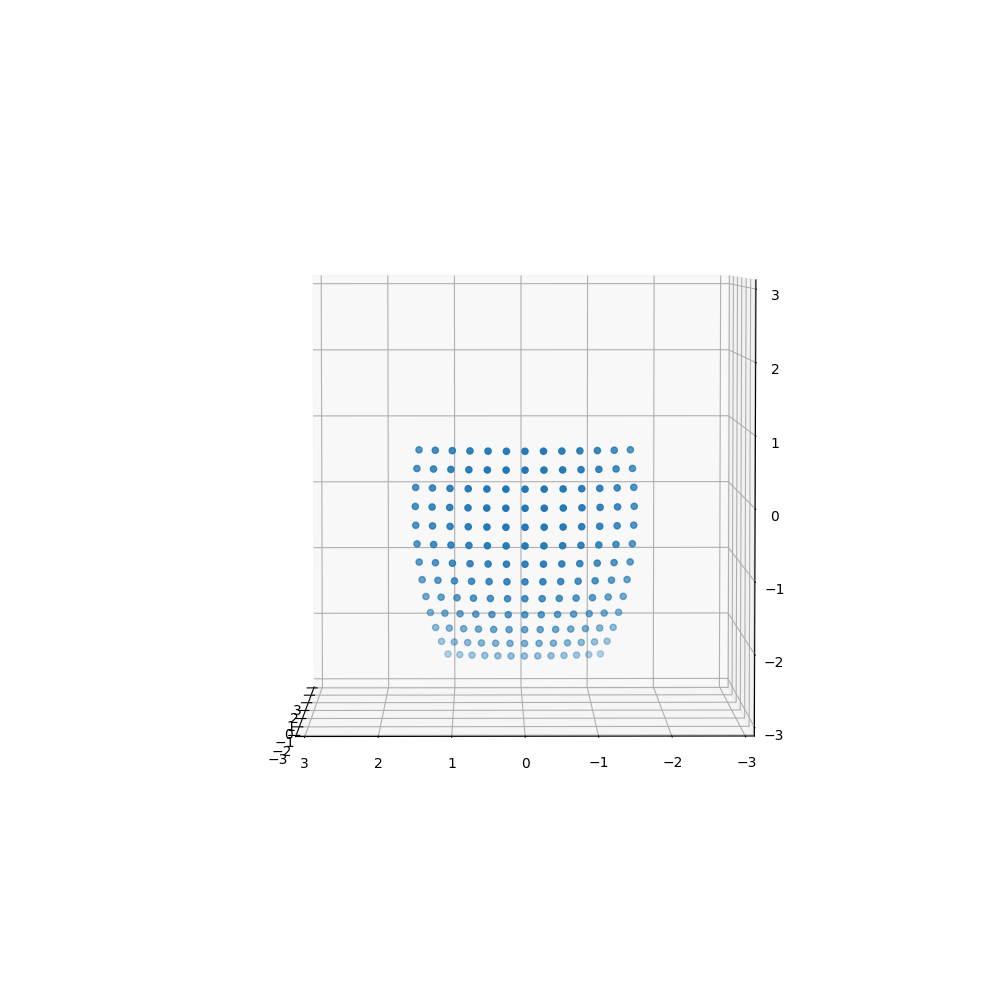

In [61]:
coords = []
xs = []
ys = []
zs = []
d = 3
for euler in desired_eulers:
    x, y, z = getXYZ(d, euler[0], euler[1])
    xs.append(x)
    ys.append(y)
    zs.append(z)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs, ys, zs)
ax.set_zlim(-d, d)
ax.set_xlim(-d, d)
ax.set_ylim(-d, d)
plt.show()

In [22]:
def gen_eofe_fp_tasks(orig_dir, filename, dest_parent, dest_dirname, dest_prefix):
    dest_root = os.path.join(dest_parent, dest_dirname)
    if not os.path.exists(dest_root):
        os.makedirs(dest_root)
    orig_path = os.path.join(orig_dir, filename)
    dest_path = os.path.join(dest_root, dest_dirname)
    fp_to_intensities(orig_path, dest_path)

    # ===================================
    print('config files')
    config_name = f'{dest_dirname}.config'
    n_tasks = len(list(os.listdir(dest_path)))
    dest_config_path = os.path.join(dest_root, config_name)
    with open(dest_config_path, 'w+') as f:
        for i in range(n_tasks):
            exe_str = '/home/cyang019/coding/projects/dnpsoup/build/dnpsoup_cli/dnpsoup_exec'
            common_str = f'/home/cyang019/workspace/CE/tasks/{dest_prefix}/{dest_dirname}'
            file_part = f'{common_str}/{dest_dirname}/fp_{i}.json'
            output_part = f'{common_str}/{dest_dirname}_results/fp_{i}.result'
            line = f'{i} {exe_str} {file_part} {output_part}\n'
            f.write(line)
    print('finished.')

    # ================================
    print('sbatch file')
    sbatch_name = f'CE_fp.sh'
    dest_sbatch_path = os.path.join(dest_root, sbatch_name)
    with open(dest_sbatch_path, 'w+') as f:
        f.write('#!/bin/bash\n')
        f.write('#SBATCH -p sched_mit_psfc\n')
        f.write(f'#SBATCH --ntasks={n_tasks}\n')
        f.write('#SBATCH --cpus-per-task=1\n')
        f.write('#SBATCH -J CE\n')
        f.write('#SBATCH --export=OMP_NUM_THREADS,ALL\n')
        f.write('module rm gcc/4.8.4\n')
        f.write('module add gcc/8.3.0\n')
        f.write('module load gcc/8.3.0\n')
        f.write('\n# launch the code\n')
        f.write('export OMP_NUM_THREAD=1\n')
        f.write(f'srun --multi-prog {config_name}\n')

    # =================================
    print('reference jobs...')
    common_name = filename.split('.')[0]
    filename2 = f'{common_name}_ref.json'
    dest_dirname2 = f'{dest_dirname}_ref'

    with open(orig_path, 'r', encoding='utf-8') as f:
        temp = json.load(f)
    temp['pulseseq']['components']['emr1']['e']['frequency'] = 0
    orig_path = os.path.join(orig_dir, filename2)
    dest_path = os.path.join(dest_root, dest_dirname2)
    with open(orig_path, 'w', encoding='utf-8') as f:
        json.dump(temp, f, indent=2)
    fp_to_intensities(orig_path, dest_path)

    # ===================================
    print('config files')
    config_name = f'{dest_dirname2}.config'
    n_tasks = len(list(os.listdir(dest_path)))
    dest_config_path = os.path.join(dest_root, config_name)
    with open(dest_config_path, 'w+') as f:
        for i in range(n_tasks):
            exe_str = '/home/cyang019/coding/projects/dnpsoup/build/dnpsoup_cli/dnpsoup_exec'
            common_str = f'/home/cyang019/workspace/CE/tasks/{dest_prefix}/{dest_dirname}'
            file_part = f'{common_str}/{dest_dirname2}/fp_{i}.json'
            output_part = f'{common_str}/{dest_dirname2}_results/fp_{i}.result'
            line = f'{i} {exe_str} {file_part} {output_part}\n'
            f.write(line)

    # ================================
    print('sbatch file')
    sbatch_name = f'CE_fp_ref.sh'
    dest_sbatch_path = os.path.join(dest_root, sbatch_name)
    with open(dest_sbatch_path, 'w+') as f:
        f.write('#!/bin/bash\n')
        f.write('#SBATCH -p sched_mit_psfc\n')
        f.write(f'#SBATCH --ntasks={n_tasks}\n')
        f.write('#SBATCH --cpus-per-task=1\n')
        f.write('#SBATCH -J CE\n')
        f.write('#SBATCH --export=OMP_NUM_THREADS,ALL\n')
        f.write('module rm gcc/4.8.4\n')
        f.write('module add gcc/8.3.0\n')
        f.write('module load gcc/8.3.0\n')
        f.write('\n# launch the code\n')
        f.write('export OMP_NUM_THREAD=1\n')
        f.write(f'srun --multi-prog {config_name}\n')
    print('finished.')

### Prepare Original dnpsoup tasks

In [26]:
import json
import re
from copy import deepcopy

In [24]:
os.getcwd()

'/home/chen/coding/projects/dnpsoup/dnpsoup_analytics/eofe_inputs'

In [62]:
# update coordinates and gammaB1 within the input file
orig_root = '../inputs/CE/TEKPol/ZCW_3angles/eulers/'
template_filename = 'TEKPol_eeH_an10bn140g0_t1e0p6ms_t2e3us_t1n2s_t2n1ms_0p4MHz_3s_inc40ns_ZCW34_g12_fp51.json'
template_path = os.path.join(orig_root, template_filename)
with open(template_path, 'r', encoding='utf-8') as f:
    data = json.load(f)

distance = 3 # Anstrom
spin_str = 'eeH'
t1e = 0.5e-3
t2e = 0.1e-6
t1n = 2
t2n = 1e-3

zcw_str = 'ZCW34_g12'
emr_val = 0.4

emr_str = str(emr_val).replace('.', 'p')
emr = f'{emr_str}MHz'
dest_root = f'../inputs/CE/TEKPol/ZCW_3angles/eulers/batch_tasks_eulers_2'

if not os.path.exists(dest_root):
    os.makedirs(dest_root)

for euler in desired_eulers:
    a, b, g = euler
    x, y, z = getXYZ(distance, a, b)0
    temp = deepcopy(data)
    temp['spinsys']['spins']['3']['x'] = x
    temp['spinsys']['spins']['3']['y'] = y
    temp['spinsys']['spins']['3']['z'] = z
    t_str = f't1e{t1e*1e3:.1f}ms_t2e{t2e*1e6:.1f}us_t1n{t1n:.1f}s_t2n{t2n*1e3:.1f}ms'
    t_str = t_str.replace('.', 'p')
    temp['spinsys']['spins']['0']['t1'] = t1e
    temp['spinsys']['spins']['0']['t2'] = t2e
    temp['spinsys']['spins']['1']['t1'] = t1e
    temp['spinsys']['spins']['1']['t2'] = t2e
    temp['spinsys']['spins']['3']['t1'] = t1n
    temp['spinsys']['spins']['3']['t2'] = t2n
    temp['pulseseq']['components']['emr1']['e']['frequency'] = emr_val * 1e6
    euler_str = f'a{a}b{b}g{g}'
    euler_str = euler_str.replace('-', 'n')
    new_name = f'{spin_str}_d{distance}_{euler_str}_{t_str}_{emr}.json'
    new_path = os.path.join(dest_root, new_name)
    with open(new_path, 'w', encoding='utf-8') as f:
        json.dump(temp, f, indent=2)
    print('.', end='')
print()
print('Finished.')

.........................................................................................................................................................................
Finished.


In [40]:
# update mixing times
orig_root = '../inputs/CE/TEKPol/ZCW_3angles/eulers/'
template_filename = 'TEKPol_eeH_an10bn140g0_t1e0p6ms_t2e3us_t1n2s_t2n1ms_0p4MHz_3s_inc40ns_ZCW34_g12_fp51.json'
template_path = os.path.join(orig_root, template_filename)
with open(template_path, 'r', encoding='utf-8') as f:
    data = json.load(f)

distance = 2.36 # Anstrom
spin_str = 'eeH'
euler_str = 'a0bn105g0'
euler_pattern = r'a(n?\d+)b(n?\d+)g(n?\d+)'
m = re.search(euler_pattern, euler_str)
a, b, g = m.group(1), m.group(2), m.group(3)
a = float(a.replace('n', '-'))
b = float(b.replace('n', '-'))
g = float(g.replace('n', '-'))
t_str = 't1e0p6ms_t2e3us_t1n2s_t2n1ms'
zcw_str = 'ZCW34_g12'
emr_val = 0.4
mixing_time = 1 # seconds
mixing_time_str = f'{mixing_time:.2f}'.replace('.', 'p')

emr_str = str(emr_val).replace('.', 'p')
emr = f'{emr_str}MHz'
dest_root = f'../inputs/CE/TEKPol/ZCW_3angles/eulers/batch_tasks_mixing_time'

desired_mixing_times = np.arange(0.2, 4, 0.2)

if not os.path.exists(dest_root):
    os.makedirs(dest_root)

for mixing_time in desired_mixing_times:
    temp = deepcopy(data)
    x, y, z = getXYZ(distance, a, b)
    temp['spinsys']['spins']['3']['x'] = x
    temp['spinsys']['spins']['3']['y'] = y
    temp['spinsys']['spins']['3']['z'] = z
    temp['pulseseq']['components']['emr1']['e']['frequency'] = emr_val * 1e6
    inc = float(temp['pulseseq']['increment'])
    temp['pulseseq']['sections']['cw']['size'] = int(mixing_time/inc)
    mixing_time_str = f'{mixing_time:.2f}'.replace('.', 'p')
    new_name = f'{spin_str}_{euler_str}_{t_str}_{emr}_{mixing_time_str}_inc40ns_ZCW34_g12_fp51.json'0
    new_path = os.path.join(dest_root, new_name)
    with open(new_path, 'w', encoding='utf-8') as f:
        json.dump(temp, f, indent=2)
    print('.', end='')
print()
print('Finished.')

...................
Finished.


In [37]:
# update distances
orig_root = '../inputs/CE/TEKPol/ZCW_3angles/eulers/'
template_filename = 'TEKPol_eeH_an10bn140g0_t1e0p6ms_t2e3us_t1n2s_t2n1ms_0p4MHz_3s_inc40ns_ZCW34_g12_fp51.json'
template_path = os.path.join(orig_root, template_filename)
with open(template_path, 'r', encoding='utf-8') as f:
    data = json.load(f)

# distance = 2.36 # Anstrom
spin_str = 'eeH'
euler_str = 'a0bn105g0'
euler_pattern = r'a(n?\d+)b(n?\d+)g(n?\d+)'
m = re.search(euler_pattern, euler_str)
a, b, g = m.group(1), m.group(2), m.group(3)
a = float(a.replace('n', '-'))
b = float(b.replace('n', '-'))
g = float(g.replace('n', '-'))
t_str = 't1e0p6ms_t2e3us_t1n2s_t2n1ms'
zcw_str = 'ZCW34_g12'
emr_val = 0.4
mixing_time = 3 # seconds
mixing_time_str = f'{mixing_time:.2f}'.replace('.', 'p')

emr_str = str(emr_val).replace('.', 'p')
emr = f'{emr_str}MHz'
dest_root = f'../inputs/CE/TEKPol/ZCW_3angles/eulers/batch_tasks_distance'

if not os.path.exists(dest_root):
    os.makedirs(dest_root)

desired_distances = [
    2.36, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0, 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 4.0, 4.5, 5.0
]
    
for distance in desired_distances:
    temp = deepcopy(data)
    x, y, z = getXYZ(distance, a, b)
    temp['spinsys']['spins']['3']['x'] = x
    temp['spinsys']['spins']['3']['y'] = y
    temp['spinsys']['spins']['3']['z'] = z
    temp['pulseseq']['components']['emr1']['e']['frequency'] = emr_val * 1e6
    inc = float(temp['pulseseq']['increment'])
    temp['pulseseq']['sections']['cw']['size'] = int(mixing_time/inc)
    mixing_time_str = f'{mixing_time:.1f}'.replace('.', 'p')
    d_str = f'd{distance:.2f}'.replace('.', 'p')
    new_name = f'{spin_str}_{d_str}_{euler_str}_{t_str}_{emr}_{mixing_time_str}_inc40ns_ZCW34_g12_fp51.json'
    new_path = os.path.join(dest_root, new_name)
    with open(new_path, 'w', encoding='utf-8') as f:
        json.dump(temp, f, indent=2)
    print('.', end='')4
print()
print('Finished.')

...................
Finished.


In [51]:
# Look for combinations of t1e, t2e, and t2n
t1es = [3e-3, 2e-3, 1e-3, 0.7e-3, 0.6e-3, 0.5e-3, 0.4e-3]
t2es = [1e-6, 5e-7, 3e-7, 2e-7, 1e-7]
t2ns = [1e-3]

orig_root = '../inputs/CE/TEKPol/ZCW_3angles/eulers/'
template_filename = 'TEKPol_eeH_an10bn140g0_t1e0p6ms_t2e3us_t1n2s_t2n1ms_0p4MHz_3s_inc40ns_ZCW34_g12_fp51.json'
template_path = os.path.join(orig_root, template_filename)
with open(template_path, 'r', encoding='utf-8') as f:
    data = json.load(f)

distance = 3 # Anstr
spin_str = 'eeH'
euler_str = 'a0bn105g0'
# euler_pattern = r'a(n?\d+)b(n?\d+)g(n?\d+)'
# m = re.search(euler_pattern, euler_str)
# a, b, g = m.group(1), m.group(2), m.group(3)
# a = float(a.replace('n', '-'))
# b = float(b.replace('n', '-'))
# g = float(g.replace('n', '-'))

zcw_str = 'ZCW34_g12'
emr_val = 0.4
mixing_time = 3 # seconds
mixing_time_str = f'{mixing_time:.2f}'.replace('.', 'p')

emr_str = str(emr_val).replace('.', 'p')
emr = f'{emr_str}MHz'
dest_root = f'../inputs/CE/TEKPol/ZCW_3angles/eulers/batch_tasks_relaxation_2'

if not os.path.exists(dest_root):
    os.makedirs(dest_root)

t1n = 2
for t1e in t1es:
    for t2e in t2es:
        for t2n in t2ns:
            temp = deepcopy(data)
            t_str = f't1e{t1e*1e3:.1f}ms_{t2e*1e6:.1f}us_t1n{t1n:.1f}_t2n{t2n*1e3:.1f}ms'
            t_str = t_str.replace('.', 'p')
            temp['spinsys']['spins']['0']['t1'] = t1e
            temp['spinsys']['spins']['0']['t2'] = t2e
            temp['spinsys']['spins']['1']['t1'] = t1e
            temp['spinsys']['spins']['1']['t2'] = t2e
            temp['spinsys']['spins']['3']['t1'] = t1n
            temp['spinsys']['spins']['3']['t2'] = t2n
            x, y, z = getXYZ(distance, a, b)
            temp['spinsys']['spins']['3']['x'] = x
            temp['spinsys']['spins']['3']['y'] = y
            temp['spinsys']['spins']['3']['z'] = z
            temp['pulseseq']['components']['emr1']['e']['frequency'] = emr_val * 1e6
            inc = float(temp['pulseseq']['increment'])
            temp['pulseseq']['sections']['cw']['size'] = int(mixing_time/inc)
            mixing_time_str = f'{mixing_time:.1f}'.replace('.', 'p')
            d_str = f'd{distance:.2f}'.replace('.', 'p')
            new_name = f'{spin_str}_{d_str}_{euler_str}_{t_str}_{emr}_{mixing_time_str}_inc40ns_ZCW34_g12_fp51.json'
            new_path = os.path.join(dest_root, new_name)
            with open(new_path, 'w', encoding='utf-8') as f:
                json.dump(temp, f, indent=2)
            print('.', end='')
print()
print('Finished.')

...................................
Finished.


### Prepare eofe Tasks

In [63]:
orig_dir = deepcopy(dest_root)
dest_prefix = 'batch_tasks_eulers_2'
dest_dir = f'./CE/TEKPol_fp/{dest_prefix}'

if not os.path.exists(dest_dir):
    os.makedirs(dest_dir)
    
for filename in os.listdir(orig_dir):
    if not filename.endswith('.json'):
        continue
    elif filename.endswith('ref.json'):
        continue
    dest_name = filename.split('.')[0]
    gen_eofe_fp_tasks(orig_dir, filename, dest_dir, dest_name, dest_prefix)
    print(f'{dest_name} produced.')

break task [FieldProfile] into individual intensities...
....................................................
config files
finished.
sbatch file
reference jobs...
break task [FieldProfile] into individual intensities...
....................................................
config files
sbatch file
finished.
eeH_d3_an25bn115g0_t1e0p5ms_t2e0p1us_t1n2p0s_t2n1p0ms_0p4MHz produced.
break task [FieldProfile] into individual intensities...
....................................................
config files
finished.
sbatch file
reference jobs...
break task [FieldProfile] into individual intensities...
....................................................
config files
sbatch file
finished.
eeH_d3_a0bn100g0_t1e0p5ms_t2e0p1us_t1n2p0s_t2n1p0ms_0p4MHz produced.
break task [FieldProfile] into individual intensities...
....................................................
config files
finished.
sbatch file
reference jobs...
break task [FieldProfile] into individual intensities...
........................

....................................................
config files
sbatch file
finished.
eeH_d3_a0bn120g0_t1e0p5ms_t2e0p1us_t1n2p0s_t2n1p0ms_0p4MHz produced.
break task [FieldProfile] into individual intensities...
....................................................
config files
finished.
sbatch file
reference jobs...
break task [FieldProfile] into individual intensities...
....................................................
config files
sbatch file
finished.
eeH_d3_a30bn85g0_t1e0p5ms_t2e0p1us_t1n2p0s_t2n1p0ms_0p4MHz produced.
break task [FieldProfile] into individual intensities...
....................................................
config files
finished.
sbatch file
reference jobs...
break task [FieldProfile] into individual intensities...
....................................................
config files
sbatch file
finished.
eeH_d3_an10bn120g0_t1e0p5ms_t2e0p1us_t1n2p0s_t2n1p0ms_0p4MHz produced.
break task [FieldProfile] into individual intensities...
..............................

....................................................
config files
sbatch file
finished.
eeH_d3_a5bn115g0_t1e0p5ms_t2e0p1us_t1n2p0s_t2n1p0ms_0p4MHz produced.
break task [FieldProfile] into individual intensities...
....................................................
config files
finished.
sbatch file
reference jobs...
break task [FieldProfile] into individual intensities...
....................................................
config files
sbatch file
finished.
eeH_d3_an20bn100g0_t1e0p5ms_t2e0p1us_t1n2p0s_t2n1p0ms_0p4MHz produced.
break task [FieldProfile] into individual intensities...
....................................................
config files
finished.
sbatch file
reference jobs...
break task [FieldProfile] into individual intensities...
....................................................
config files
sbatch file
finished.
eeH_d3_an20bn80g0_t1e0p5ms_t2e0p1us_t1n2p0s_t2n1p0ms_0p4MHz produced.
break task [FieldProfile] into individual intensities...
.............................

....................................................
config files
finished.
sbatch file
reference jobs...
break task [FieldProfile] into individual intensities...
....................................................
config files
sbatch file
finished.
eeH_d3_an30bn100g0_t1e0p5ms_t2e0p1us_t1n2p0s_t2n1p0ms_0p4MHz produced.
break task [FieldProfile] into individual intensities...
....................................................
config files
finished.
sbatch file
reference jobs...
break task [FieldProfile] into individual intensities...
....................................................
config files
sbatch file
finished.
eeH_d3_an5bn115g0_t1e0p5ms_t2e0p1us_t1n2p0s_t2n1p0ms_0p4MHz produced.
break task [FieldProfile] into individual intensities...
....................................................
config files
finished.
sbatch file
reference jobs...
break task [FieldProfile] into individual intensities...
....................................................
config files
sbatch file
fi

....................................................
config files
sbatch file
finished.
eeH_d3_an20bn125g0_t1e0p5ms_t2e0p1us_t1n2p0s_t2n1p0ms_0p4MHz produced.
break task [FieldProfile] into individual intensities...
....................................................
config files
finished.
sbatch file
reference jobs...
break task [FieldProfile] into individual intensities...
....................................................
config files
sbatch file
finished.
eeH_d3_an10bn125g0_t1e0p5ms_t2e0p1us_t1n2p0s_t2n1p0ms_0p4MHz produced.
break task [FieldProfile] into individual intensities...
....................................................
config files
finished.
sbatch file
reference jobs...
break task [FieldProfile] into individual intensities...
....................................................
config files
sbatch file
finished.
eeH_d3_a25bn125g0_t1e0p5ms_t2e0p1us_t1n2p0s_t2n1p0ms_0p4MHz produced.
break task [FieldProfile] into individual intensities...
...........................

....................................................
config files
finished.
sbatch file
reference jobs...
break task [FieldProfile] into individual intensities...
....................................................
config files
sbatch file
finished.
eeH_d3_an10bn85g0_t1e0p5ms_t2e0p1us_t1n2p0s_t2n1p0ms_0p4MHz produced.
break task [FieldProfile] into individual intensities...
....................................................
config files
finished.
sbatch file
reference jobs...
break task [FieldProfile] into individual intensities...
....................................................
config files
sbatch file
finished.
eeH_d3_an25bn130g0_t1e0p5ms_t2e0p1us_t1n2p0s_t2n1p0ms_0p4MHz produced.
break task [FieldProfile] into individual intensities...
....................................................
config files
finished.
sbatch file
reference jobs...
break task [FieldProfile] into individual intensities...
....................................................
config files
sbatch file
fi

....................................................
config files
finished.
sbatch file
reference jobs...
break task [FieldProfile] into individual intensities...
....................................................
config files
sbatch file
finished.
eeH_d3_a20bn110g0_t1e0p5ms_t2e0p1us_t1n2p0s_t2n1p0ms_0p4MHz produced.
break task [FieldProfile] into individual intensities...
....................................................
config files
finished.
sbatch file
reference jobs...
break task [FieldProfile] into individual intensities...
....................................................
config files
sbatch file
finished.
eeH_d3_a10bn85g0_t1e0p5ms_t2e0p1us_t1n2p0s_t2n1p0ms_0p4MHz produced.
break task [FieldProfile] into individual intensities...
....................................................
config files
finished.
sbatch file
reference jobs...
break task [FieldProfile] into individual intensities...
....................................................
config files
sbatch file
fini

....................................................
config files
sbatch file
finished.
eeH_d3_a10bn130g0_t1e0p5ms_t2e0p1us_t1n2p0s_t2n1p0ms_0p4MHz produced.
break task [FieldProfile] into individual intensities...
....................................................
config files
finished.
sbatch file
reference jobs...
break task [FieldProfile] into individual intensities...
....................................................
config files
sbatch file
finished.
eeH_d3_a30bn130g0_t1e0p5ms_t2e0p1us_t1n2p0s_t2n1p0ms_0p4MHz produced.
break task [FieldProfile] into individual intensities...
....................................................
config files
finished.
sbatch file
reference jobs...
break task [FieldProfile] into individual intensities...
....................................................
config files
sbatch file
finished.
eeH_d3_an10bn100g0_t1e0p5ms_t2e0p1us_t1n2p0s_t2n1p0ms_0p4MHz produced.
break task [FieldProfile] into individual intensities...
............................

....................................................
config files
sbatch file
finished.
eeH_d3_an25bn110g0_t1e0p5ms_t2e0p1us_t1n2p0s_t2n1p0ms_0p4MHz produced.


In [42]:
2.5/np.sqrt(2)

1.7677669529663687